# Predicting Pitch Location

The goal of this notebook is to implement the paper titled "Prediction of pitch type and location in baseball using ensemble model of deep neural networks" by Lee (2022)

# Data acquisition

In [1]:
import numpy as np
import pandas as pd

Using a custom function, I pull all of Wade Miley’s pitches from the 2015–2018 and 2021 seasons, the same years used in the study. Miley’s data was used for training in the study because he was determined to be the most difficult pitcher to predict, which provides a useful lower bound for model performance.

In [2]:
import os

os.chdir('..')
data = pd.read_csv(os.path.join('data', 'raw', 'wade_miley_15-21.csv'))

In [3]:
import tensorflow as tf

tf.random.set_seed(42)

## Feature Engineering
This paper uses the following 8 features:

Before engineering these features, I created a new ID column to group pitches by unique at-bat. This will be used to divide the data into chronological sequences for the LSTM model.

In [4]:
data.loc[:,'plate_app_id'] =  data['game_pk'].astype(str) + data['batter'].astype(str) + data['at_bat_number'].astype(str)

With pitch count, inning, ball count, and outs already in the data, I engineered the rest of the features with custom functions and simple pandas operations.

In [5]:
data = data.sort_values(['game_date',
                         'game_pk', # Handle double headers
                         'plate_app_id',
                         'pitch_number'], ascending=True)

In [6]:
def score_diff(row):
    if row['inning_topbot'] == 'Top':
        return row['home_score'] - row['away_score']
    else:
        return row['away_score'] - row['home_score']

In [7]:
# Create previous pitch column
data.loc[:,'previous_pitch'] = data['pitch_type'].shift(1)
data.loc[data['pitch_number'] == 1, 'previous_pitch'] = None

# Create previous zone column
data.loc[:,'previous_zone'] = data['zone'].shift(1)
data.loc[data['pitch_number'] == 1, 'previous_zone'] = None

# Encode runners on base
on_base_cols = ['on_3b', 'on_2b', 'on_1b']
for col in on_base_cols:
  data.loc[:,col] = data[col].fillna(0).astype(int)
  data.loc[data[col] != 0, col] = 1

# Create score difference
data.loc[:,'score_diff'] = data.apply(score_diff, axis=1)

selected_features = [
    'plate_app_id',
    'previous_pitch',
    'previous_zone',
    'pitch_number',
    'inning',
    'on_3b', 'on_2b', 'on_1b',
    'score_diff',
    'balls', 'strikes',
    'stand',
    'outs_when_up',
    'zone'
]
selected_cols = data[selected_features]

Categorical features were then one, hot encoded. Since the paper did not mention scaling or standardizing the continuous columns, I did not do so. This may not make much of a difference as pitch count is the only continuous feature without an upper limit written into the rules of baseball and at-bats are usually about 5 pitches long.

In [8]:
# Apply one-hot encoding to categorical columns
selected_cols = pd.get_dummies(selected_cols, columns=['previous_zone', 'previous_pitch', 'inning', 'stand'], dtype=int)
selected_cols.head()

,plate_app_id,pitch_number,on_3b,on_2b,on_1b,score_diff,balls,strikes,outs_when_up,zone,...,inning_2,inning_3,inning_4,inning_5,inning_6,inning_7,inning_8,inning_9,stand_L,stand_R
10784,41369612134729,1,0.0,1.0,0.0,1,0,0,1,7.0,...,0,0,1,0,0,0,0,0,0,1
10783,41369612134729,2,0.0,1.0,0.0,1,0,1,1,4.0,...,0,0,1,0,0,0,0,0,0,1
10782,41369612134729,3,0.0,1.0,0.0,1,0,2,1,13.0,...,0,0,1,0,0,0,0,0,0,1
10781,41369612134729,4,0.0,1.0,0.0,1,1,2,1,13.0,...,0,0,1,0,0,0,0,0,0,1
10748,41369612134750,1,1.0,0.0,1.0,3,0,0,1,14.0,...,0,0,0,0,1,0,0,0,0,1


Lee (2022) manually labelled every pitch in their study a 3 by 3 grid. Statcast already divides the strikezone in 39 zones It is unknown which method is more accurate, for thi reason, three experiments will be run:
- One neural network to predict the pitch location out of the 14 original zones
- An ensemble of two neural networks to predict the pitch location out of a reduced 3 by 3 grid like in Lee (2022)

## Multi-class with 14 zones

First, let's define a naive guess for a baseline

In [9]:
most_repeated_zone = data['zone'].mode()[0]
zone_frequency = data['zone'].value_counts(normalize=True)[most_repeated_zone] * 100
print(f'The most repeated zone in the dataset is: {most_repeated_zone} with a frequency of {zone_frequency:.2f}%')

The most repeated zone in the dataset is: 13.0 with a frequency of 25.37%


In [10]:
from sklearn.model_selection import train_test_split

data = selected_cols.copy()
data = pd.get_dummies(data, columns=['zone'], dtype=int)
data = data.drop(columns=['plate_app_id'])

# Separate features and target
X = data.drop(columns=[col for col in data.columns if col.startswith('zone_')])
y = data[[col for col in data.columns if col.startswith('zone_')]]

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [11]:
# Define the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),  # Adjust input shape
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(13, activation='softmax')  # 39 model classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint_callback],
                    verbose=0)
model = tf.keras.models.load_model('best_model.keras')
print(f"Test Accuracy: {model.evaluate(X_test, y_test)[1]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - accuracy: 0.2660 - loss: 2.3507
Test Accuracy: 0.27209532260894775


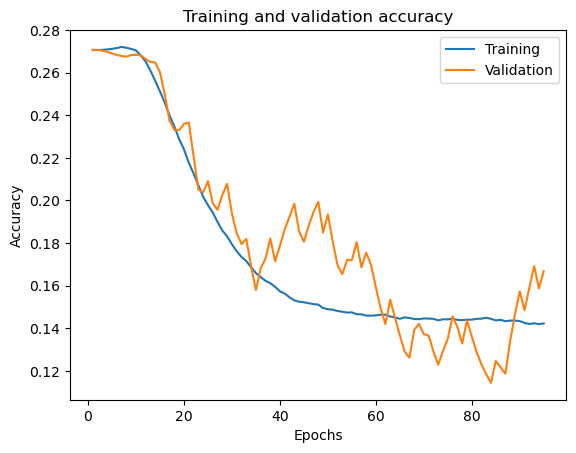

In [12]:
from utils.plot_utils import smooth_curve, plot_epochs

smooth_accuracy = smooth_curve(history.history['accuracy'][5:])
smooth_val_accuracy = smooth_curve(history.history['val_accuracy'][5:])

plot_epochs(x=range(1, len(smooth_accuracy) + 1),
            y={'Training': smooth_accuracy, 'Validation': smooth_val_accuracy},
            title='Training and validation accuracy',
            x_label='Epochs',
            y_label='Accuracy')

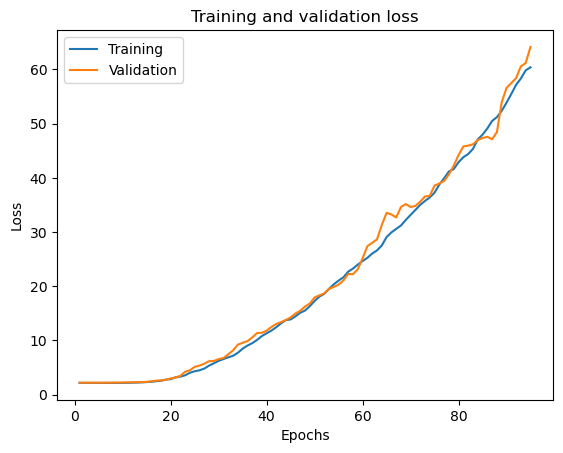

In [13]:
smooth_loss = smooth_curve(history.history['loss'][5:])
smooth_val_loss = smooth_curve(history.history['val_loss'][5:])

plot_epochs(x=range(1, len(smooth_loss) + 1),
            y={'Training': smooth_loss, 'Validation': smooth_val_loss},
            title='Training and validation loss',
            x_label='Epochs',
            y_label='Loss')

In [14]:
# Define the model with regularization and dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),  # Adjust input shape
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(13, activation='softmax')  # 39 output classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[checkpoint_callback],
                    verbose=0)
model = tf.keras.models.load_model('best_model.keras')
print(f"Test Accuracy: {model.evaluate(X_test, y_test)[1]}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 827us/step - accuracy: 0.2685 - loss: 2.2596 
Test Accuracy: 0.27308839559555054


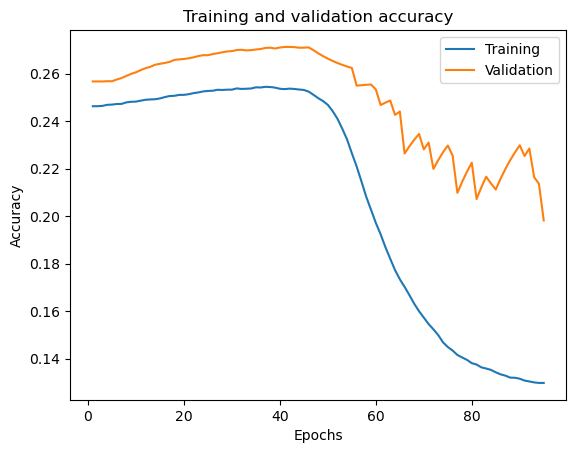

In [15]:
from utils.plot_utils import smooth_curve, plot_epochs

smooth_accuracy = smooth_curve(history.history['accuracy'][5:])
smooth_val_accuracy = smooth_curve(history.history['val_accuracy'][5:])

plot_epochs(x=range(1, len(smooth_accuracy) + 1),
            y={'Training': smooth_accuracy, 'Validation': smooth_val_accuracy},
            title='Training and validation accuracy',
            x_label='Epochs',
            y_label='Accuracy')

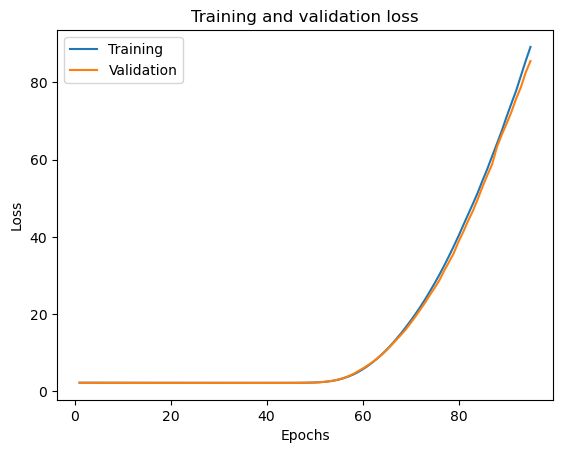

In [16]:
smooth_loss = smooth_curve(history.history['loss'][5:])
smooth_val_loss = smooth_curve(history.history['val_loss'][5:])

plot_epochs(x=range(1, len(smooth_loss) + 1),
            y={'Training': smooth_loss, 'Validation': smooth_val_loss},
            title='Training and validation loss',
            x_label='Epochs',
            y_label='Loss')

## Results

Using the model with the highest validation accuracy, I made predictions on the most recent 20% of Wade Miley’s pitches

Overall, the accuracy was quite low, at only 34%. Although this is a meaningful improvement from the baseline of 27%, it is still well below the accuracy observed in the study, which was over 60%.

In [17]:
# Print classification report
from sklearn.metrics import classification_report
y_test_argmax = np.argmax(y_test, axis=1)
preds_argmax = np.argmax(model.predict(X_test), axis=1)

print(classification_report(y_test_argmax, preds_argmax, zero_division=0))

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       105
           1       0.00      0.00      0.00        61
           2       0.00      0.00      0.00        40
           3       0.00      0.00      0.00       104
           4       0.00      0.00      0.00        90
           5       0.00      0.00      0.00        91
           6       0.00      0.00      0.00       153
           7       0.00      0.00      0.00       121
           8       0.00      0.00      0.00       133
           9       0.00      0.00      0.00       113
          10       0.00      0.00      0.00       114
          11       0.29      0.78      0.42       529
          12       0.24      0.39      0.30       360

    accuracy                           0.27      2014
   macro avg       0.04      0.09      0.06      2014
weighted avg       0.12      0.27      0.16      2014



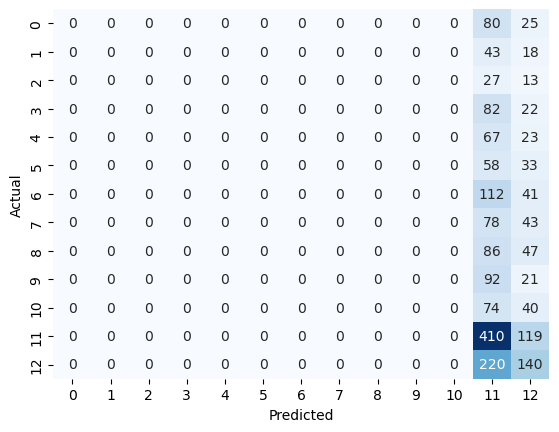

In [18]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate confusion matrix
cm = confusion_matrix(y_test_argmax, preds_argmax)

# Plot confusion matrix
plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Ensemble of two neural networks with 3 by 3 grid

In [19]:
data = selected_cols.copy()
data['vertical_location'] = data['zone'].apply(lambda x: 
                                               0 if x in [1, 2, 3, 11, 12] 
                                               else 1 if x in [4, 5, 6] 
                                               else 2)
data['horizontal_location'] = data['zone'].apply(lambda x:
                                                    0 if x in [1, 4, 7, 11, 13]
                                                    else 1 if x in [2, 5, 8]
                                                    else 2)
data = pd.get_dummies(data, columns=['vertical_location', 'horizontal_location'], dtype=int)
data = data.drop(columns=['zone', 'plate_app_id'])

# Separate features and target
X = data.drop(columns=[col for col in data.columns if col.startswith('vertical_location_') or col.startswith('horizontal_location_')])
y = data[[col for col in data.columns if col.startswith('vertical_location_') or col.startswith('horizontal_location_')]]

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [20]:
# Frequency of the most repeated vertical location
most_repeated_vertical = data[['vertical_location_0', 'vertical_location_1', 'vertical_location_2']].idxmax(axis=1).mode()[0]
vertical_frequency = data[['vertical_location_0', 'vertical_location_1', 'vertical_location_2']].sum(axis=0).max() / len(data) * 100
print(f'The most repeated vertical location in the dataset is: {most_repeated_vertical} with a frequency of {vertical_frequency:.2f}%')

# Frequency of the most repeated horizontal location
most_repeated_horizontal = data[['horizontal_location_0', 'horizontal_location_1', 'horizontal_location_2']].idxmax(axis=1).mode()[0]
horizontal_frequency = data[['horizontal_location_0', 'horizontal_location_1', 'horizontal_location_2']].sum(axis=0).max() / len(data) * 100
print(f'The most repeated horizontal location in the dataset is: {most_repeated_horizontal} with a frequency of {horizontal_frequency:.2f}%')

# Frequency of the most repeated combination


The most repeated vertical location in the dataset is: vertical_location_2 with a frequency of 65.46%
The most repeated horizontal location in the dataset is: horizontal_location_0 with a frequency of 46.24%


In [21]:
def create_dnn(num_hidden_layers, input_layer, name=''):
    # Hidden layers
    x = input_layer
    nodes_per_layer = get_num_nodes_for_layer(num_hidden_layers)
    for i in range(num_hidden_layers):
        x = tf.keras.layers.Dense(nodes_per_layer[i], activation='relu')(x)

    # Output layer
    outputs = tf.keras.layers.Dense(3, activation='softmax', name=name)(x)

    return outputs

# Function to get the number of nodes for a given hidden layer
def get_num_nodes_for_layer(layer_num):
    # Implement logic to extract node numbers from the table based on layer_num
    # For example, using a dictionary or list to store the node configurations
    node_configs = {
        3: [20, 30, 15],
        4: [20, 30, 20, 10],
        5: [20, 30, 20, 15, 9],
        6: [15, 20, 30, 20, 15, 9],
        7: [15, 20, 30, 30, 20, 15, 9],
        8: [15, 20, 25, 30, 30, 20, 15, 9],
        9: [15, 20, 25, 30, 35, 30, 25, 15, 9],
        10: [15, 20, 25, 30, 35, 35, 30, 25, 15, 9],
        11: [15, 20, 25, 30, 35, 40, 35, 30, 25, 15, 9]
    }
    return node_configs[layer_num]

In [22]:
# Define the input layer
input_layer = tf.keras.layers.Input(shape=(X_train.shape[1],))

# Define the first model for vertical location
vertical_output = create_dnn(10, input_layer, name='vertical_output')

# Define the second model for horizontal location
horizontal_output = create_dnn(10, input_layer, name='horizontal_output')

# Combine the models
ensemble_model = tf.keras.models.Model(inputs=input_layer, outputs=[vertical_output, horizontal_output])

# Compile the model
ensemble_model.compile(optimizer='adam',
                       loss={'vertical_output': 'categorical_crossentropy', 'horizontal_output': 'categorical_crossentropy'},
                       metrics=['accuracy', 'accuracy'])

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_ensemble_model.keras',
    monitor='val_vertical_output_accuracy',
    save_best_only=True,
    mode='max'
)

# Train the model
history = ensemble_model.fit(X_train, 
                             {'vertical_output': y_train[[col for col in y_train.columns if col.startswith('vertical_location_')]],
                              'horizontal_output': y_train[[col for col in y_train.columns if col.startswith('horizontal_location_')]]},
                             epochs=100, batch_size=64, 
                             validation_data=(X_val, 
                                              {'vertical_output': y_val[[col for col in y_val.columns if col.startswith('vertical_location_')]],
                                               'horizontal_output': y_val[[col for col in y_val.columns if col.startswith('horizontal_location_')]]}),
                             callbacks=[checkpoint_callback],
                             verbose=0
                            )

ensemble_model = tf.keras.models.load_model('best_ensemble_model.keras')
test_loss, vertical_accuracy, horizontal_accuracy = ensemble_model.evaluate(X_test, 
                                                                            {'vertical_output': y_test[[col for col in y_test.columns if col.startswith('vertical_location_')]],
                                                                             'horizontal_output': y_test[[col for col in y_test.columns if col.startswith('horizontal_location_')]]})
print(f"Vertical Test Accuracy: {vertical_accuracy}")
print(f"Horizontal Test Accuracy: {horizontal_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - horizontal_output_accuracy: 0.4533 - loss: 1.9146 - vertical_output_accuracy: 0.6338  
Vertical Test Accuracy: 0.46226415038108826
Horizontal Test Accuracy: 0.6593843102455139


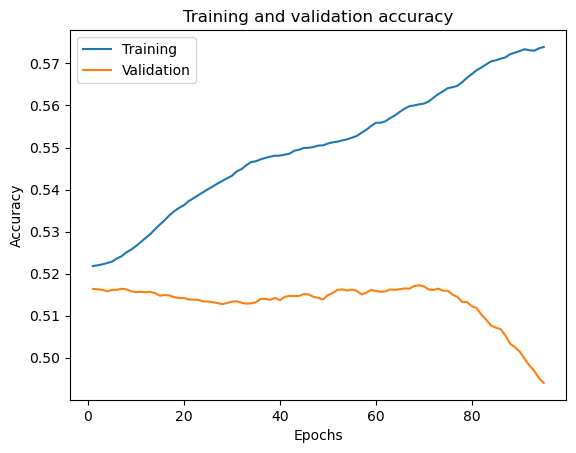

In [23]:
smooth_accuracy = smooth_curve(history.history['horizontal_output_accuracy'][5:])
smooth_val_accuracy = smooth_curve(history.history['val_horizontal_output_accuracy'][5:])

plot_epochs(x=range(1, len(smooth_accuracy) + 1),
            y={'Training': smooth_accuracy, 'Validation': smooth_val_accuracy},
            title='Training and validation accuracy',
            x_label='Epochs',
            y_label='Accuracy')

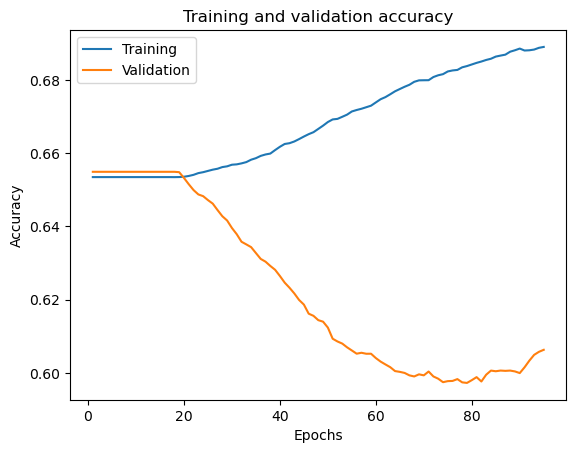

In [24]:
smooth_accuracy = smooth_curve(history.history['vertical_output_accuracy'][5:])
smooth_val_accuracy = smooth_curve(history.history['val_vertical_output_accuracy'][5:])

plot_epochs(x=range(1, len(smooth_accuracy) + 1),
            y={'Training': smooth_accuracy, 'Validation': smooth_val_accuracy},
            title='Training and validation accuracy',
            x_label='Epochs',
            y_label='Accuracy')

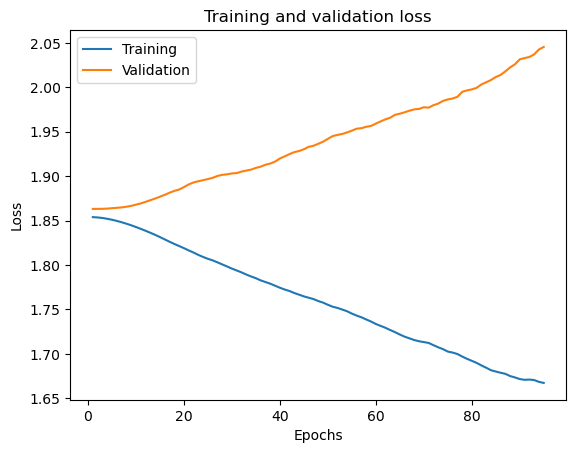

In [25]:
smooth_loss = smooth_curve(history.history['loss'][5:])
smooth_val_loss = smooth_curve(history.history['val_loss'][5:])

plot_epochs(x=range(1, len(smooth_loss) + 1),
            y={'Training': smooth_loss, 'Validation': smooth_val_loss},
            title='Training and validation loss',
            x_label='Epochs',
            y_label='Loss')

## Results

In [26]:
# Make predictions
vertical_preds = np.argmax(ensemble_model.predict(X_test)[0], axis=1)
horizontal_preds = np.argmax(ensemble_model.predict(X_test)[1], axis=1)

# Actual values
vertical_actual = np.argmax(y_test[[col for col in y_test.columns if col.startswith('vertical_location_')]].values, axis=1)
horizontal_actual = np.argmax(y_test[[col for col in y_test.columns if col.startswith('horizontal_location_')]].values, axis=1)

# Calculate accuracy for each prediction
vertical_accuracy = np.mean(vertical_preds == vertical_actual)
horizontal_accuracy = np.mean(horizontal_preds == horizontal_actual)

# Calculate overall accuracy
overall_accuracy = np.mean((vertical_preds == vertical_actual) & (horizontal_preds == horizontal_actual))

print(f'Vertical Location Accuracy: {vertical_accuracy:.2f}')
print(f'Horizontal Location Accuracy: {horizontal_accuracy:.2f}')
print(f'Overall Accuracy: {overall_accuracy:.2f}')


63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Vertical Location Accuracy: 0.66
Horizontal Location Accuracy: 0.46
Overall Accuracy: 0.32


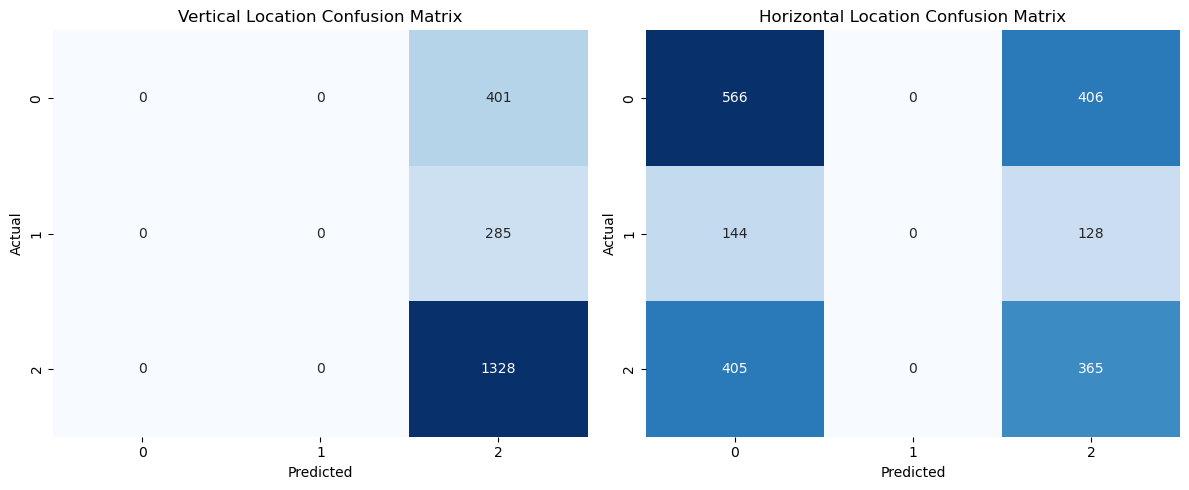

In [27]:
# Calculate confusion matrices
vertical_cm = confusion_matrix(vertical_actual, vertical_preds)
horizontal_cm = confusion_matrix(horizontal_actual, horizontal_preds)

# Plot confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(vertical_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[0])
ax[0].set_title('Vertical Location Confusion Matrix')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('Actual')

sns.heatmap(horizontal_cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax[1])
ax[1].set_title('Horizontal Location Confusion Matrix')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()